In [1]:
import pandas as pd
import numpy as np
'''
we shouldn't need to import any pre-processing libraries for now,
though perhaps after discovering which features are significant
we will have to process the data more (i.e. remove insignificant features)
'''
## Algorithm (Method)
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier # not sure why this import is unresolved... may have to pip install on my kernel

# Analysis and Postprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 

In [15]:
# loading pre-processed data

train = pd.read_csv("enc_train.csv")
X_train = train.drop(columns=["target"])
print(f"Before feature selection, we have {len(X_train.columns)} features")
y_train = train["target"]

test = pd.read_csv("enc_test.csv")
X_test = test.drop(columns=["target"])
y_test = test["target"]

Before feature selection, we have 25 features


In [4]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, y_pred, y_prob, algorithm_name):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix - {algorithm_name}:")
    print(cm)

    # Plot Confusion Matrix as Heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdBu", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix - {algorithm_name}")
    plt.xlabel("predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(f"Classification Report - {algorithm_name}:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.title(f"ROC Curve - {algorithm_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

## Naive Bayes

Confusion Matrix - Naive Bayes:
[[ 47  41]
 [ 14 198]]


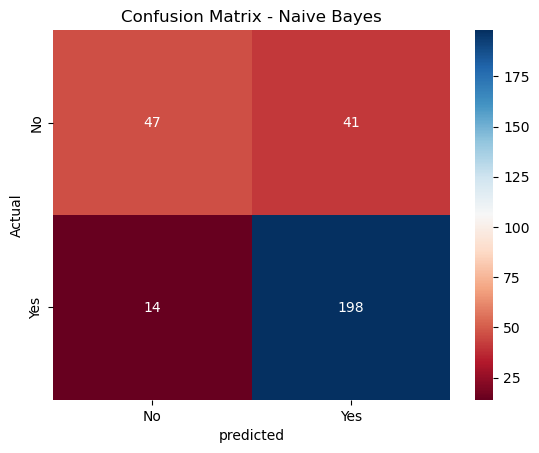

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       0.77      0.53      0.63        88
           1       0.83      0.93      0.88       212

    accuracy                           0.82       300
   macro avg       0.80      0.73      0.75       300
weighted avg       0.81      0.82      0.81       300



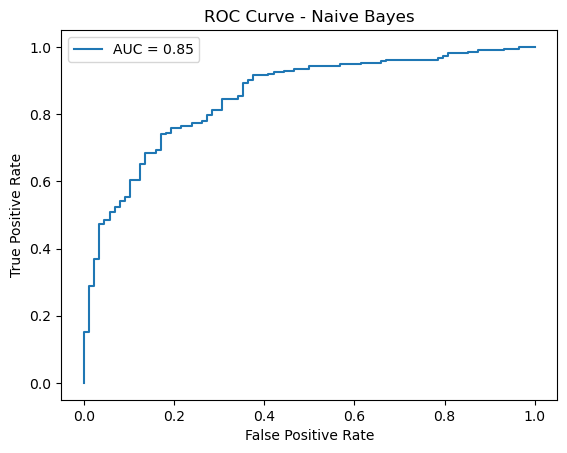

In [16]:
# 2. Naive Bayes
# Train Gaussian Naive Bayes and make predictions
# Choose a model: Gaussian (numeric), Bernoulli (binary), Multinomial (Multiclass)
# nb_model = GaussianNB()
nb_model = BernoulliNB(alpha=1.0)
# nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]
evaluate_model(nb_model, X_test, y_test, nb_pred, nb_prob, "Naive Bayes")

## Logistic Regression

Confusion Matrix - Logistic Regression:
[[ 50  38]
 [ 16 196]]


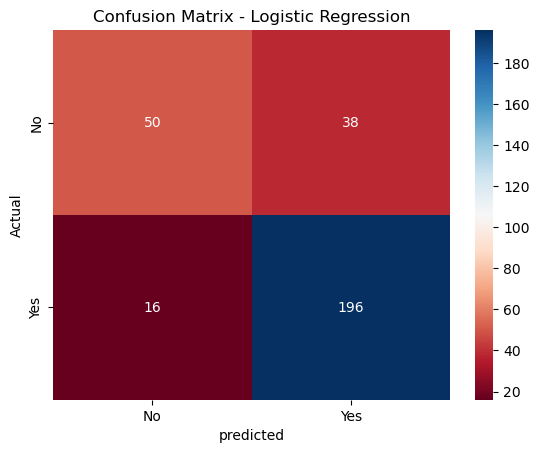

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        88
           1       0.84      0.92      0.88       212

    accuracy                           0.82       300
   macro avg       0.80      0.75      0.76       300
weighted avg       0.81      0.82      0.81       300



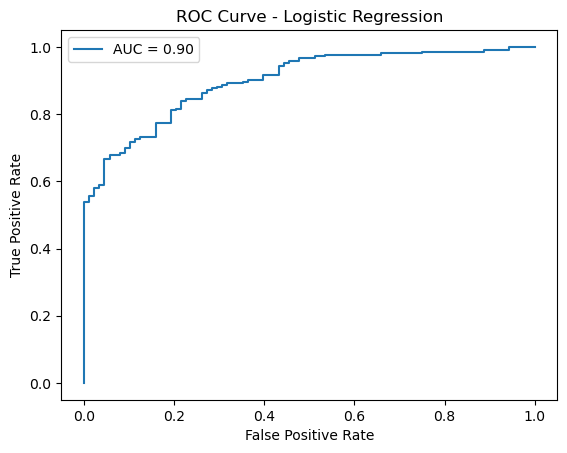

In [6]:
# 3. Logistic Regression
# Train Logistic Regression with default solver and make predictions
log_model = LogisticRegression(solver="liblinear")
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_prob = log_model.predict_proba(X_test)[:, 1]
evaluate_model(log_model, X_test, y_test, log_pred, log_prob, "Logistic Regression")

## Using Logistic Regression to Find Significant Features

* We hope that this will reduce the number of necessary features for our final model

Recall that f is a significant feature if and only if p<0.05

In [5]:
X = pd.concat([X_train, X_test], ignore_index=True)

y = pd.concat([y_train, y_test], ignore_index=True)
y=y.astype('category')

X = sm.add_constant(X) #add constant
logis = sm.Logit(y,X)

logistic_coef = logis.fit()
logistic_coef.summary2()

Optimization terminated successfully.
         Current function value: 0.386246
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: target           Pseudo R-squared: 0.372      
Date:               2025-05-03 18:02 AIC:              1056.2391  
No. Observations:   1300             BIC:              1190.6622  
Df Model:           25               Log-Likelihood:   -502.12    
Df Residuals:       1274             LL-Null:          -799.97    
Converged:          1.0000           LLR p-value:      9.5274e-110
No. Iterations:     7.0000           Scale:            1.0000     
--------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const       1.4522     0.4772    3.0434   0.0023    0.5170    2.3873
f1_Cat      0.2424     0.1976    1.2267   0.2199   -0.1449    0.6297
f1_Dog      0.0670     0.1955    0.3425   0.7320   -0.3162    0.4501
f2          0.1022     0.0840    1.2161   0.2239   -0.0625    0.2669
f3         -0.1183     0.0975   -1.2126   0.2253   -0.3094    0.0729
f4          0.0079     0.0700    0.1126   0.9104   -0.1292    0.1450
f5_Green    0.2051     0.2031    1.0097   0.3127   -0.1930    0.6032
f5_Red      0.1601     0.1935    0.8272   0.4081   -0.2192    0.5394
f6          0.2512     0.0764    3.2885   0.0010    0.1015    0.4009
f7_No      -0.3466     0.1942   -1.7849   0.0743   -0.7273    0.0340
f7_Yes     -0.3582     0.1961   -1.8270   0.0677   -0.7426    0.0261
f8          0.1073     0.0285    3.7656   0.0002    0.0515    0.1632
f9_Y        0.0241     0.1910    0.1263   0.8995   -0.3502    0.3984
f9_Z       -0.1039     0.2006   -0.5181   0.6044   -0.4971    0.2892
f16_B       1.3191     0.1910    6.9050   0.0000    0.9447    1.6936
f16_C      -0.1794     0.2032   -0.8831   0.3772   -0.5776    0.2188
f10         1.9736     0.1274   15.4886   0.0000    1.7239    2.2234
f11        -0.1136     0.0980   -1.1595   0.2462   -0.3057    0.0784
f12        -0.0866     0.0414   -2.0924   0.0364   -0.1676   -0.0055
f13         0.0462     0.0805    0.5734   0.5664   -0.1116    0.2040
f14        -0.0333     0.0803   -0.4149   0.6782   -0.1908    0.1241
f15         2.0938     0.2214    9.4587   0.0000    1.6600    2.5277
f17        -0.0384     0.0799   -0.4809   0.6306   -0.1951    0.1182
f18        -0.0167     0.0768   -0.2173   0.8280   -0.1673    0.1339
f19         0.0899     0.0759    1.1836   0.2366   -0.0589    0.2386
f20        -0.1326     0.0555   -2.3873   0.0170   -0.2414   -0.0237
==================================================================

"""

From the above output, we can see that the following features are insignificant with 95% confidence:
* f1_Cat
* f1_Dog
* f2
* f3
* f4
* f5_Green
* f5_Red
* f7_No
* f7_Yes
* f9_Y
* f9_Z
* f16_C   <--- Note that since f16_B is significant, we must keep f16_C as well, since these features are related via one-hot encoding (one of them being significant implies that the other is significant as well)
* f11
* f13
* f14
* f17
* f18
* f19

Therefore we will drop all of these, except f16_C

In [9]:
# significant_train = train.drop(columns=["f1_Cat","f1_Dog","f2",
#                                         "f3","f4","f5_Green",
#                                         "f5_Red","f7_No","f7_Yes",
#                                         "f9_Y","f9_Z","f11",
#                                         "f13","f14","f17",
#                                         "f18","f19"])

# significant_test = test.drop(columns=["f1_Cat","f1_Dog","f2",
#                                         "f3","f4","f5_Green",
#                                         "f5_Red","f7_No","f7_Yes",
#                                         "f9_Y","f9_Z","f11",
#                                         "f13","f14","f17",
#                                         "f18","f19"])

# Only need to make the files once!
# # Now saving significant features to new .csv files
# significant_train.to_csv("significant_train.csv", index=False)
# significant_test.to_csv("significant_test.csv", index=False)

## Running Naive Bayes and Logistic Regression with Significant Features

In [17]:
# reloading train & test from the significant features datasets

train = pd.read_csv("significant_train.csv")
X_train = train.drop(columns=["target"])
y_train = train["target"]

test = pd.read_csv("significant_test.csv")
X_test = test.drop(columns=["target"])
y_test = test["target"]

### Naive Bayes (with Significant Features)

Confusion Matrix - Naive Bayes:
[[ 43  45]
 [ 11 201]]


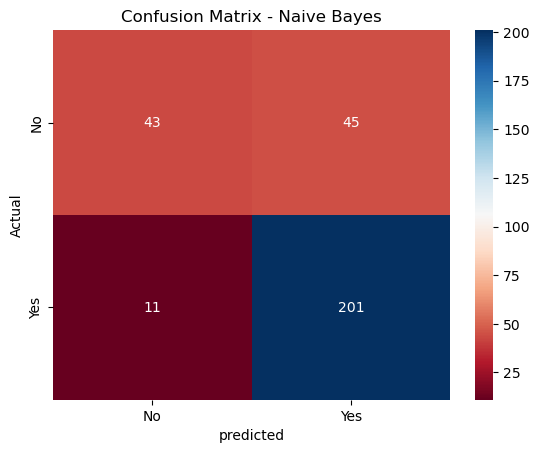

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           0       0.80      0.49      0.61        88
           1       0.82      0.95      0.88       212

    accuracy                           0.81       300
   macro avg       0.81      0.72      0.74       300
weighted avg       0.81      0.81      0.80       300



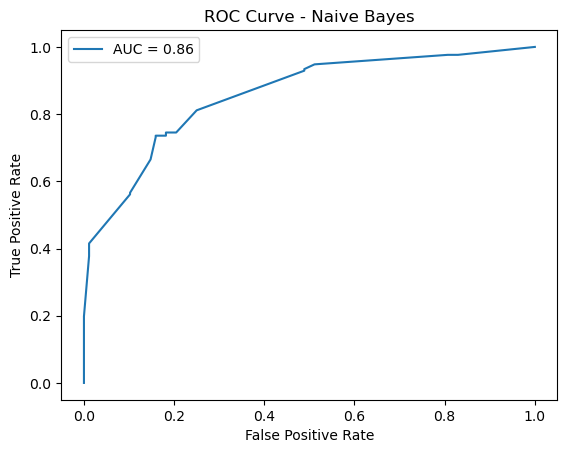

In [11]:
# Choose a model: Gaussian (numeric), Bernoulli (binary), Multinomial (Multiclass)
# nb_model = GaussianNB()
nb_model = BernoulliNB(alpha=1.0)
# nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]
evaluate_model(nb_model, X_test, y_test, nb_pred, nb_prob, "Naive Bayes")

# We get the same f1-score with way less features!!!

### Logistic Regression (With Significant Features)

Confusion Matrix - Logistic Regression:
[[ 52  36]
 [ 11 201]]


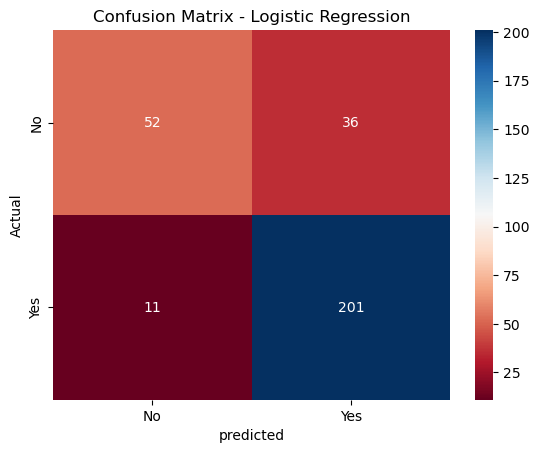

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        88
           1       0.85      0.95      0.90       212

    accuracy                           0.84       300
   macro avg       0.84      0.77      0.79       300
weighted avg       0.84      0.84      0.83       300



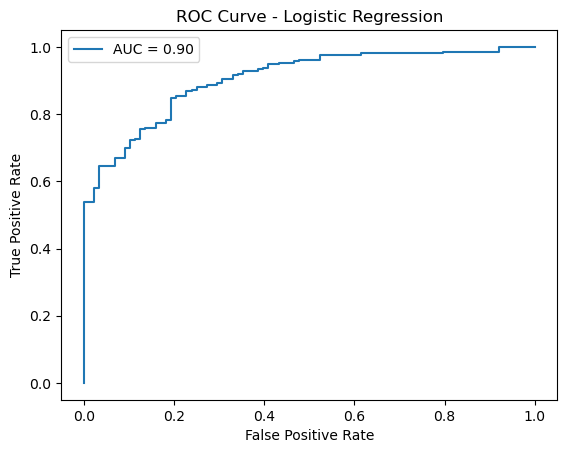

In [18]:
# Train Logistic Regression with default solver and make predictions
log_model = LogisticRegression(solver="liblinear")
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_prob = log_model.predict_proba(X_test)[:, 1]
evaluate_model(log_model, X_test, y_test, log_pred, log_prob, "Logistic Regression")

# We get a higher f1-score with less features!!!